In [4]:
#importing libraries
import pandas as pd


import re
import nltk
import string
import gensim

from sklearn.svm import SVC
from nltk import word_tokenize 
from nltk import sent_tokenize
import matplotlib.pyplot as plt
from sklearn import preprocessing
from gensim.models import word2vec 
from sklearn.metrics import roc_curve
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
wn1=WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
StOP_WORDS=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#cloning dataset
!git clone https://github.com/SmallLion/Python-Projects.git

Cloning into 'Python-Projects'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 114 (delta 33), reused 32 (delta 32), pack-reused 76
Receiving objects: 100% (114/114), 278.15 KiB | 8.69 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [6]:
#reading the dataset
df = pd.read_csv("Python-Projects/Spam-detection/spam.csv", encoding = 'latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ã_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [7]:
#saving only labels and data column in the dataframe
df = df[['v1','v2']]
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ã_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
#Encoding labels
enc = LabelEncoder()
df['v1'] = enc.fit_transform(df['v1'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#labels after being encoded
df

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ã_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [10]:
#removing characters that are not letters or number or down case
def clean_sentence(val):
    "remove chars that are not letters or number or down case then remove"
    regex=re.compile('([^\s\w]|_)+')
    sentence=regex.sub('',val).lower()
    sentence=sentence.split(" ")
    for word in list(sentence):
        if word in  StOP_WORDS:
            sentence.remove(word)
    sentence=" ".join(sentence)
    return sentence

In [11]:
#dropping null then applying clean sentence function created in above cell
def clean_dataframe(data):
    "drop nans,then apply clean sentence function to description"
    data=data.dropna(how="any")
    for col in ['v2']:
        data[col]=data[col].apply(clean_sentence)
    return data

In [12]:
#calling above function and passing dataframe to it. Getting cleaned data
df = clean_dataframe(df)
df.head(5)

,v1,v2
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


In [13]:
#creating corpus of the dataframe. 
#corpus is the list of words present in the dataframe
def build_corpus(data):
    "creat a list of lists containing words for each sentence"
    corpus=[]
    for col in ['v2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")  
            corpus.append(word_list)   
    return corpus  

In [14]:
#calling above function passing dataframe and getting resulting corpus
corpus=build_corpus(df)
corpus[0:10]

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni'],
 ['free',
  'entry',
  '2',
  'wkly',
  'comp',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  '21st',
  'may',
  '2005',
  'text',
  'fa',
  '87121',
  'receive',
  'entry',
  'questionstd',
  'txt',
  'ratetcs',
  'apply',
  '08452810075over18s'],
 ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'],
 ['nah', 'dont', 'think', 'goes', 'usf', 'lives', 'around', 'though'],
 ['freemsg',
  'hey',
  'darling',
  '3',
  'weeks',
  'word',
  'back',
  'id',
  'like',
  'fun',
  'still',
  'tb',
  'ok',
  'xxx',
  'std',
  'chgs',
  'send',
  'ãâ150',
  'rcv'],
 ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent'],
 ['per',
  'request',
  'melle',
  'melle',
  'oru',
  'minnaminunginte',
  'nurungu',
  'vettam',
  'set',
  'callertune',
  'callers',
  'pr

In [15]:
#passing parameters and creating wordtovec variable
model = word2vec.Word2Vec(corpus, size=5, window=20, min_count=2, workers=4) 

In [16]:
#function will create vectors for each word using above wordtovec
def vectorfun(data):
    vector=[]
    for n in data.split():
            try:
             vector.extend(model.wv[n])
            except:
                pass
    return vector

In [17]:
#passing data column to above function to create vectors of the words and creating new test dataframe
test=pd.DataFrame(df['v2'].apply(vectorfun).tolist())

In [18]:
#vectors we got
test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
0,0.002184,6.031165,0.489096,-3.323153,3.626446,0.006627,0.803336,0.092440,-0.467537,0.406934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.068437,3.624041,0.186810,-2.043338,2.035854,-0.051213,1.891153,0.110333,-0.943841,0.928419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.511802,5.926926,0.185409,-2.488398,3.620281,0.180518,2.128051,0.116274,-0.942914,1.255013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.131802,5.877113,0.255872,-3.366794,3.573080,0.002059,2.808523,0.149355,-1.509084,1.603924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.042451,0.522664,0.078182,-0.214340,0.384954,-0.211973,5.216115,0.651018,-2.877130,2.939668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#replacing nan/null vectors with zero
test.fillna(0,inplace=True)

In [20]:
#adding label column in the test dataframe
test['v1']=df['v1']

In [21]:
test

,0,1,2,3,4,5,6,7,8,9,...,331,332,333,334,335,336,337,338,339,v1
0,0.002184,6.031165,0.489096,-3.323153,3.626446,0.006627,0.803336,0.092440,-0.467537,0.406934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.068437,3.624041,0.186810,-2.043338,2.035854,-0.051213,1.891153,0.110333,-0.943841,0.928419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.511802,5.926926,0.185409,-2.488398,3.620281,0.180518,2.128051,0.116274,-0.942914,1.255013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.131802,5.877113,0.255872,-3.366794,3.573080,0.002059,2.808523,0.149355,-1.509084,1.603924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.042451,0.522664,0.078182,-0.214340,0.384954,-0.211973,5.216115,0.651018,-2.877130,2.939668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.244410,2.071652,-0.047033,-0.953602,1.119344,0.028875,4.774632,0.454172,-2.658906,2.685789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5568,-0.015387,3.677200,0.158123,-2.130075,1.870862,0.131215,3.217678,0.159030,-1.823985,1.886572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5569,0.030479,0.606501,0.117913,-0.293489,0.370998,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5570,0.118447,1.900121,0.156994,-1.125231,1.128076,0.049473,0.197172,0.096970,-0.000452,0.134499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [22]:
#taking text as input and labels as output
#i.e. X will have all columns except label column y will have only label column
X =test.drop('v1',axis=1)
y=test['v1']

In [23]:
#splitting data into testing and training part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [24]:
#making variable for SVM
clfsvm=SVC(probability=True)

In [25]:
#fitting training data into SVM
clfsvm.fit(X_train, y_train)

SVC(probability=True)

In [26]:
#after training, passing model the test features to predict
y_pred=clfsvm.predict(X_test)

In [27]:
#calculating accuracy
accuracy=accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 91.93 %.


In [28]:
#printing confusion matrix
confusion_matrix(y_test, y_pred)

array([[1406,   14],
       [ 121,  131]])

In [29]:
#predicting probabilty in order to draw rox curve
pred_prob1 = clfsvm.predict_proba(X_test)

In [30]:
#calculating TPR FPR and thresholds
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
# roc curve for tpr fpr 
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


In [31]:
#accuracy score
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
print(auc_score1)

0.9437220545495194


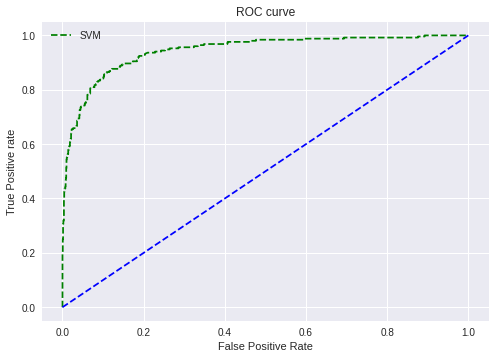

In [32]:
#plotting ROC Curve graph
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='green', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();